<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">
    Être ou ne pas être ?
</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">
    Un problème de classification binaire sur des données médicales artificelles
<br/>

---

# Membres du groupe

**Minimum 2, Maximum 3**

* BOUNEGTA Mohamed Rami
* BERKENNOU Brahim
* BOUGHADOU Kenzi

# Présentation du challenge

## La question principale de ce challenge est : 

* Comment prédire la survie d'un·e patient·e compte tenu de son dossier médical ? 
    
* Plus précisément, vous devrez prédire la survie des patient·e·s pendant leur séjour à l'hôpital
 
Chaque jour, le personnel soignant collecte de nombreuses informations sur les patient·e·s en posant des questions et en utilisant des outils de mesure (stéthoscope, analyse de sang, capteurs, etc.). Ces données sont très utiles pour surveiller l'état de santé, diagnostiquer et choisir les traitements.

Elles peuvent également être utilisées pour l'analyse statistique prédictive.

## Données

L'ensemble de données contient des informations sur 80'000 patient·e·s, représentés par des variables (descripteurs) catégorielles, binaires et numériques. Ces variables sont, par exemple, l'âge, le sexe, l'origine ethnique, l'état matrimonial, ainsi que des données médicales telles que la tension artérielle ou le taux de glucose. Il y a un total de 342 variables.

La classe (étiquette ou label) à prédire est une variable binaire indiquant si la·le patient·e est décédé·e ou non pendant son séjour à l'hôpital. Heureusement, la plupart survivent :

![](img/tobe.png)

## Tâche

La tâche consiste à créer un modèle capable d'apprendre à partir des données et de faire des prédictions (apprentissage supervisé). Chaque instance (patient·e) possède une variable indiquant si elle·il est décédé·e ou non pendant son séjour à l'hôpital.

Références et crédit :

Isabelle Guyon, Kristin Bennett, Andrew Yale, Adrien Pavao, Thomas Gerspacher

## Instructions

Le but de ce TP est de travailler sur un challenge de prédiction de la mortalité.

Le lien vers le challenge :
https://competitions.codalab.org/competitions/30715

* **Étape 1 :** S'enregistrer sur https://competitions.codalab.org
* **Étape 2:** Téléchargez le jeu de données à partir de la [page](https://competitions.codalab.org/competitions/30715#participate-get_starting_kit) "Participate > Files > Public Data". Placez le dossier "public_data" dans le même dossier que celui contenant ce notebook.
* **Étape 3:** Parcourez ce notebook. Vous devrez lire, exécuter, **coder vos propres méthodes** et **répondre aux questions**. Utilisez la cellule ***code*** pour le codage et la cellule ***markdown*** pour répondre aux questions.

## Évaluation du projet

* **4 points** pour la partie compréhension et analyse exploratoire
    
* **4 points** pour un code propre et bien documenté

* **4 points** pour la qualité du modèle (sélection du modèle, sélection des hyperparamètres)

* **4 points** pour une bonne évaluation des performances du modèle

* **4 points** pour l'originalité et la complétude de la solution 

* **1 point bonus** pour l'équipe gagnante du challenge

### FAQ

* Soumettre uniquement le notebook sur eCampus

* La partie texte (explications, résultats, problèmes, sans le code) ne doit pas dépasser 3 pages A4 11pt (< 1500 mots)

# Challenge

Module particulier requis : `imblearn` (à installer avec `conda` ou `pip`)

* `conda install -c conda-forge imbalanced-learn`

* `pip install imbalanced-learn`

In [1]:
from datetime import datetime
from pathlib import Path
from zipfile import ZipFile

import imblearn
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import (
    decomposition,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    preprocessing,
    svm,
    tree,
    neighbors
)

In [2]:
%reload_ext autoreload
%autoreload 2

%config InlineBackend.figure_format="retina"  # For high DPI display

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.4g}".format

## 1. Compréhension du problème

### Expliquez brièvement la tâche avec vos mots

<b>
-La tâche est  : de créer et implementer un modéle qui apprendra à partir des différents types de données récoltées sur le patient pour prédir si ce dérnier est décédé ou a survecu pendant son séjour à l'hopital.

-le but est d'essayer d'implementer un modéle que lors de sa prediction on aura la même état prédit que celui mentionné dans la variable de chaque patient s'il est décédé ou pas pendant son séjour à l'hôpital.
</b>    

### Métrique utilisée

Pourquoi la métrique utilisée ici est la [`sklearn.metrics.balanced_accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) plutôt que simplement l'[`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) ?

<b>
  Car dans ce probléme l'ensemble des données est un ensemble déséquilibré vu qu'il contient une classe majoritaire(survived) et une autre minoritaire(died) qui sont concernées par la prédiction qui sera faite.
Donc l'utilisation de la métrique sklearn.metrics.balanced_accuracy_score donnera un résultat plus fiable pour le score de la prédiction.
</b>    

## 2. Chargement des données

In [3]:
DATA = Path(
    "public_data"
).expanduser()

 #DATA = Path("public_data")

PRED_PATH = Path("Submissions")

DROP_VARS = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "HADM_ID"]

In [4]:
features = pd.read_csv(
    DATA / "mimic_synthetic_feat.name", header=None
).values.flatten()

labels = pd.read_csv(
    DATA / "mimic_synthetic_label.name", header=None
).values.flatten()

x_df = pd.read_csv(
    DATA / "mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_df.drop(columns=DROP_VARS, inplace=True)

ys = pd.Series(
    pd.read_csv(
        DATA / "mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [5]:
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.21,108.7,70.84,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.33,121.1,96.92,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118.2,175.2,140.9,...,0,0,0,0,0,0,0,0,0,0


C'est **l'ensemble d'entrainement**. Cela signifie que vous avez accès aux étiquettes et que vous pouvez l'utiliser comme vous le souhaitez pour préparer votre modèle.

Plus tard, vous ferez en sorte que votre modèle tire des prédictions de **l'ensemble de test** afin de les téléverser sur Codalab et d'obtenir un score sur des données non vues lors de l'entrainement des modèles.

In [6]:
# Load test set
x_test_df = pd.read_csv(
    DATA / "mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_test_df.drop(columns=DROP_VARS, inplace=True)


## 3. Analyse exploratoire

#### Types des variables

In [7]:
types = pd.read_csv(DATA / "mimic_synthetic_feat.type", header=None).set_index(
    features
)[0]

types.value_counts()

Numerical      226
Binary         107
Categorical      8
Name: 0, dtype: int64

#### Distribution de la variable cible

In [10]:
ys.describe()

count     8e+04
mean    0.03496
std      0.1837
min           0
25%           0
50%           0
75%           0
max           1
dtype: float64

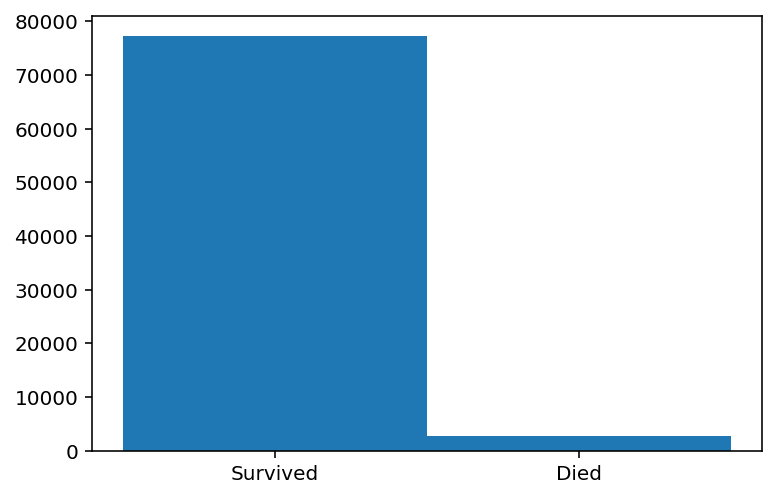

In [8]:
ys.hist(bins=2, grid=False, align="left")
plt.xticks([0, 0.5], ["Survived", "Died"])
# plt.savefig("img/tobe.png", dpi=300)
plt.show()

### Code : Produire les graphiques suivants

* Diagrammes à barres de certaines variables catégorielles (par exemple "LANGUAGE", "MARITAL_STATUS")

* Montrez la corrélation entre certaines variables et la variable cible y

* Un autre graphique ou toute analyse exploratoire à laquelle vous pouvez penser

Exemple

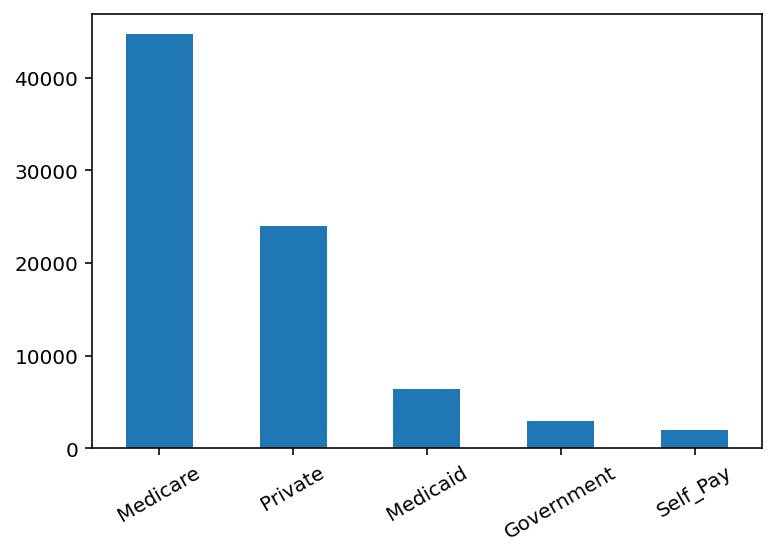

In [9]:
x_marital_cnts = x_df["INSURANCE"].value_counts()
x_marital_cnts.plot.bar(rot=30)
plt.show()

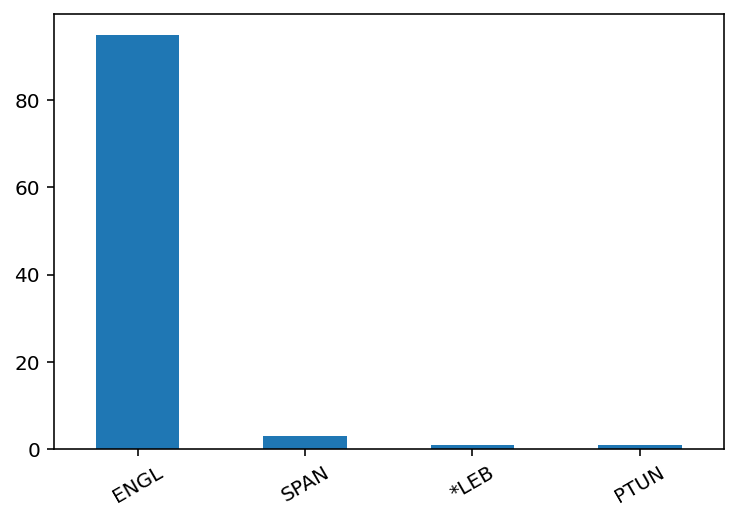

In [10]:
#  Bar plot of another variable
x_marital_cnts = x_df["LANGUAGE"][:100].value_counts()
x_marital_cnts.plot.bar(rot=30)
plt.show()

#### Corrélations

AGE                -0.008814
HR_MIN_DAY1       -0.0008231
HR_MAX_DAY1        -0.007995
HR_MEAN_DAY1       -0.008683
SYS_BP_MIN_DAY1     0.006196
                     ...    
Othnervdx          -0.000807
Hrtvalvedx           -0.0032
Carditis            0.001444
HTN                 0.003797
Htncomplicn         -0.01392
Length: 330, dtype: float64

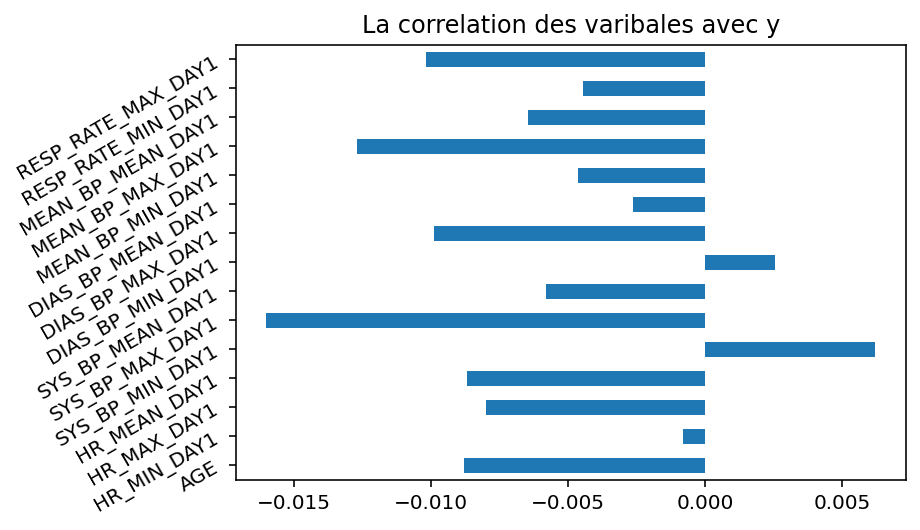

In [11]:
#application de la fonction de correlation avec ys.
corr_df = x_test_df.corrwith(ys , axis =0 , drop=False )
plt.title('La correlation des varibales avec y')
#choix des 15 premiéres features pour le dessin du diagramme des barres horizontales
#Pour que ça soit visible
corr_df[:15].plot.barh(rot=30)
#l'affichage des valeurs sans le diagramme.
display(corr_df)

Astuce :

* Utilisez un graphique avec des barres horizontales `barh` (pour visualiser les valeurs positives et négatives)

<b>Commentaire :</b>Dans le résultat de la correlation des varibales avec y on a : 330/337 variable comme résultat.
Certaines ont une correlation postive et d'autres négative. 

<b>Par exemple </b> : La correlation de la feature "AGE" avec y est négative comme on peut le visualiser avec le diagramme et celle de "Carditis" est positive.

<b> Autre analyse exploiratoire : </b>

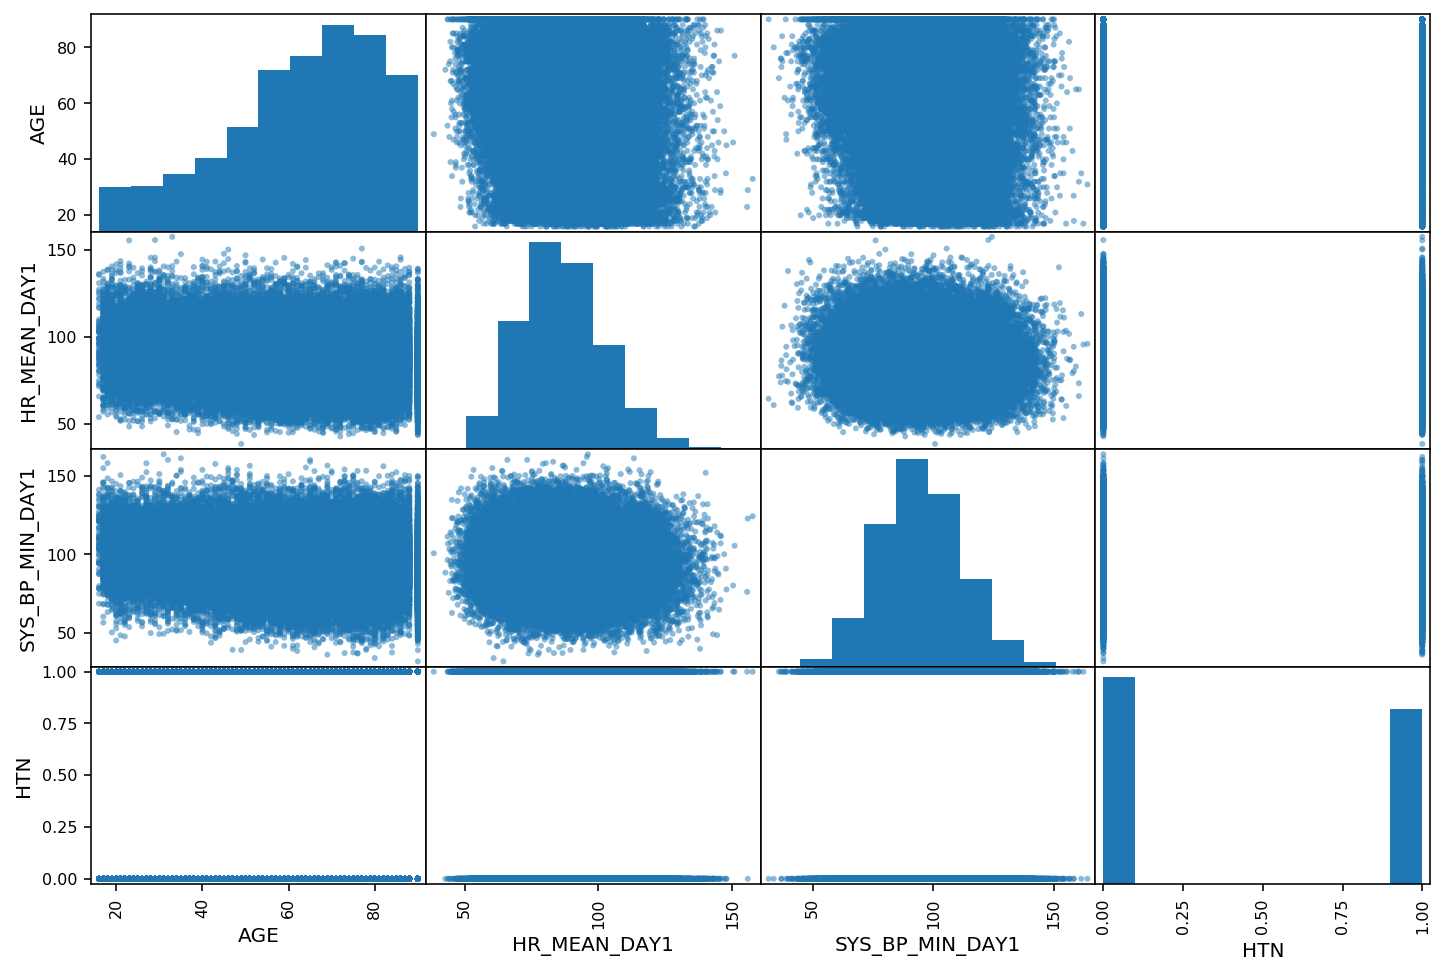

In [16]:
FTS = ["AGE", "HR_MEAN_DAY1", "SYS_BP_MIN_DAY1", "HTN"]
pd.plotting.scatter_matrix(x_df[FTS], figsize=(12, 8))
plt.show()

<b> Commentaire : </b>Pour bien visualiser la correlation entre les features contenues dans le dataset, on a appliqué la scatter_matrix pour tracer la correclation entre chaque feature et une autre feature, comme on a 337 features on a choisi d'appliquer la fonction seulement sur 4 descripteurs pour que ça soit bien lisible sur une page.

<b>Observation : </b>on peut voir la correlation positive entre les deux variables "HR_MIN_DAY1" et "HR_MAX_DAY1",la correlation à valeur zero entre ces dérnières et la varibale "AGE", tant dis qu'on a des variables peu corrélées comme "Htncomplicn" car c'est une varibale binaire comme on peut le constater sur le diagramme [12:12] du tableau.

## 4. Pre-traitement

### Code : Traitement du problème des valeurs manquantes (ou non définies, NAN)

La solution la plus simple est d'éliminer l'ensemble des colonnes où il y a des données manquantes, mais on perd de l'information. 

Vu le faible nombre d'instances concernées (maximum 6 : voir ci-dessous) il parait plus pertinent de supprimer les lignes (instances) plutôt que les colonnes entières (variables).

La solution que nous choisissons ici est une troisième, celle de remplacer les valeurs non définies par la valeur la plus probable de la variable. Comme ces valeurs manquantes concernent exclusivement des variables catégorielles et binaires, la valeur la plus probable est le *mode* (voir cours : `part-5-slides.pdf`).

In [17]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


In [18]:
x_nans = x_df.isna().sum()
x_miss = x_nans[x_nans > 0]
x_miss

LANGUAGE                              1
MARITAL_STATUS                        1
ICU                                   2
ECodes:Adverseeffectsofmedicalcare    6
Otnutritdx                            2
Othnervdx                             1
dtype: int64

In [19]:
x_test_nans = x_test_df.isna().sum()
x_test_miss = x_test_nans[x_test_nans > 0]
x_test_miss

LANGUAGE                              2
ECodes:Adverseeffectsofmedicalcare    3
dtype: int64

In [20]:
x_miss_rows = x_df.isna().any(axis="columns")

x_df.loc[x_miss_rows, x_miss.index]

,LANGUAGE,MARITAL_STATUS,ICU,ECodes:Adverseeffectsofmedicalcare,Otnutritdx,Othnervdx
2251,ENGL,MARRIED,MICU,nan,0,0
9983,ENGL,MARRIED,MICU,0,nan,0
10549,ENGL,MARRIED,MICU,0,nan,0
10831,ENGL,MARRIED,MICU,nan,1,0
17012,ENGL,MARRIED,CSRU,nan,0,1
23088,ENGL,MARRIED,NaN,0,0,0
32539,ENGL,NaN,CSRU,0,0,0
42762,ENGL,SINGLE,TSICU,nan,0,0
53191,NaN,MARRIED,MICU,0,0,0
53390,CAPE,MARRIED,NaN,0,0,0


#### Remplacement des NAN

In [21]:
na_cols = set(x_miss.index) | set(x_test_miss.index)

for col in na_cols:
    x_df[col].fillna(x_df[col].mode()[0], inplace=True)
    x_test_df[col].fillna(x_test_df[col].mode()[0], inplace=True)

In [22]:
print(x_df.isna().any().any(), x_test_df.isna().any().any())

False False


In [23]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


### Domain Expertise

Simplifiez les données en regroupant par exemple les catégories rares.

In [24]:
def merge_rare_categories(dfs, col, keeps=None, keep_n=5):
    if keeps is None:
        keeps = x_df[col].value_counts()[:keep_n].index
        print(keeps)

    for df in dfs:
        df.loc[~df[col].isin(keeps), col] = "OTHER"


merge_rare_categories([x_df, x_test_df], col="RELIGION", keep_n=5)
print(x_test_df["RELIGION"].value_counts())

Index(['CATHOLIC', 'NOT_SPECIFIED', 'UNOBTAINABLE', 'PROTESTANT_QUAKER',
       'JEWISH'],
      dtype='object')
CATHOLIC             7517
NOT_SPECIFIED        3764
OTHER                2449
UNOBTAINABLE         2208
PROTESTANT_QUAKER    2208
JEWISH               1855
Name: RELIGION, dtype: int64


#### Code : Effectuez des regroupements de catégories rares pour d'autres variables si vous le jugez nécessaire

<b> Regroupement des catégories rares pour la variable "LANGUAGE" : </b>

In [25]:
merge_rare_categories([x_df, x_test_df], col="LANGUAGE", keep_n=1)
print(x_test_df["LANGUAGE"].value_counts())

Index(['ENGL'], dtype='object')
ENGL     18883
OTHER     1118
Name: LANGUAGE, dtype: int64


<b> Regroupement des catégories rares pour la variable "EHTNICITY" : </b>

In [26]:
merge_rare_categories([x_df, x_test_df], col="ETHNICITY", keep_n=1)
print(x_test_df["ETHNICITY"].value_counts())

Index(['WHITE'], dtype='object')
WHITE    14930
OTHER     5071
Name: ETHNICITY, dtype: int64


<b> Regroupement des catégories rares pour la variable "HTN" : </b>

In [27]:
merge_rare_categories([x_df, x_test_df], col="HTN", keep_n=1)
print(x_test_df["HTN"].value_counts())

Int64Index([0], dtype='int64')
0        10601
OTHER     9400
Name: HTN, dtype: int64


<b> Regroupement des catégories rares pour la variable "INSURANCE" : </b>

In [28]:
merge_rare_categories([x_df, x_test_df], col="INSURANCE", keep_n=1)
print(x_test_df["INSURANCE"].value_counts())

Index(['Medicare'], dtype='object')
Medicare    11250
OTHER        8751
Name: INSURANCE, dtype: int64


### Transformation des données catégorielles en nombres entiers en utilisant deux types d'encodage

Les variables catégorielles sont présentées sous forme de chaines de caractères. La plupart des modèles ne pourront pas les prendre en entrée.

#### Encodage numérique simple

Deux des méthodes les plus simples sont `LabelEncoder` de Scikit-Learn et `factorize` de pandas. Elles consistent simplement à remplacer chaque nouvelle catégorie rencontrée par un entier, en commençant par 0. Ce n'est cependant peut-être pas la méthode la plus efficace, car elle présuppose une proximité entre les catégories codées avec des valeurs proches.

In [29]:
def label_encode(df, other_df, only_binary=False):

    char_cols = df.dtypes.pipe(lambda x: x[x == "object"]).index
    # print(char_cols)

    for col in char_cols:
        n_categories = len(x_df[col].unique())

        if not only_binary or n_categories == 2:
            codes, uniques = pd.factorize(df[col])
            df[col] = codes

            # Create conversion dic to convert values of test set as well
            cat2code = {k: v for v, k in enumerate(uniques)}
            other_df[col] = other_df[col].map(cat2code)

In [30]:
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,OTHER,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.21,108.7,70.84,...,0,0,0,0,0,0,0,0,0,0
1,OTHER,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.33,121.1,96.92,...,0,0,0,0,0,0,0,0,0,1
2,OTHER,OTHER,CATHOLIC,WIDOWED,OTHER,M,40,118.2,175.2,140.9,...,0,0,0,0,0,0,0,0,0,0


In [31]:
print(x_df.shape, ys.shape)

(79999, 337) (79999,)


In [32]:
x_fact_df = x_df.copy()
x_test_fact_df = x_test_df.copy()

label_encode(x_fact_df, x_test_fact_df)

In [33]:
x_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,0,0,0,0,0,0,21,57.21,108.7,70.84,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,1,39,79.33,121.1,96.92,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,2,1,1,40,118.2,175.2,140.9,...,0,0,0,0,0,0,0,0,0,0


In [34]:
x_test_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,0,0,5,3,0,0,18,72.64,112.7,96.46,...,0,0,0,0,0,0,0,0,0,0
1,1,0,2,1,1,0,56,66.61,106.8,83.85,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,1,32,69.72,102.7,87.26,...,0,0,0,0,0,0,0,0,0,0


#### Encodage 1-Hot

Un autre type d'encodage est souvent plus efficace, il a notamment l'avantage de ne pas ordonner les classes d'une manière particulière (pas forcément en adéquation avec la proximité de ces classes entre elles).

Une méthode de pandas permet de le réaliser en 1 ligne de code avec la fonction `get_dummies`.

In [35]:
codes, uniques = pd.factorize(x_df["MARITAL_STATUS"])
cat2code = {k: v for v, k in enumerate(uniques)}
cat2code

{'DIVORCED': 0,
 'SINGLE': 1,
 'WIDOWED': 2,
 'MARRIED': 3,
 'UNKNOWN_(DEFAULT)': 4,
 'SEPARATED': 5,
 'LIFE_PARTNER': 6}

Exemple d'encodage 1-hot avec la fonction `get_dummies` de pandas (pour MARITAL_STATUS) :

|    |   DIVORCED |   LIFE_PARTNER |   MARRIED |   SEPARATED |   SINGLE |   UNKNOWN_(DEFAULT) |   WIDOWED |
|---:|-----------:|---------------:|----------:|------------:|---------:|--------------------:|----------:|
|  0 |          1 |              0 |         0 |           0 |        0 |                   0 |         0 |
|  1 |          0 |              0 |         0 |           0 |        1 |                   0 |         0 |
|  2 |          0 |              0 |         0 |           0 |        0 |                   0 |         1 |
|  3 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |
|  4 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |

In [36]:
# Encode binary features on a single column (no need for 1-hot)
label_encode(x_df, x_test_df, only_binary=True)

x_all_1hot_df = pd.get_dummies(pd.concat([x_df, x_test_df]))

x_1hot_df = x_all_1hot_df.iloc[:len(x_df)].copy()
x_test_1hot_df = x_all_1hot_df.iloc[len(x_df):].copy()

print(x_df.shape, x_test_df.shape)
print(x_1hot_df.shape, x_test_1hot_df.shape)

(79999, 337) (20001, 337)
(79999, 352) (20001, 352)


#### Suppression des variables à valeur unique (constantes)

In [37]:
const_cols = {col for col in x_1hot_df if len(x_1hot_df[col].unique()) == 1}
len(const_cols)

173

In [38]:
x_1hot_df.drop(const_cols, axis="columns", inplace=True)
x_test_1hot_df.drop(const_cols, axis="columns", inplace=True)

print(x_1hot_df.shape, x_test_1hot_df.shape)

(79999, 179) (20001, 179)


### Création de l'ensemble de validation

In [39]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    x_1hot_df, ys, test_size=0.3
)
# VARS: x_df, x_fact_df, x_1hot_df

### Réduction de la dimension via l'ACP (PCA)

Testez l'ACP pour réduire le nombre de dimensions et observez si cela améliore le résultat.

Avant d'appliquer la ACP, il est conseillé de centrer-réduire les données (e.g., via `preprocessing.StandardScaler()`).

In [40]:

N_COMP = 10

pca = decomposition.PCA(n_components=N_COMP)
#Reduction des données et application de la PCA
data_pcs = pca.fit_transform(preprocessing.StandardScaler().fit_transform(x_1hot_df))

data_pcs.shape

(79999, 10)

In [41]:
# 2. Instantiaiton
#model_pca = naive_bayes.GaussianNB()
model_pca = linear_model.LogisticRegression(max_iter=10000)
#model_pca = neighbors.KNeighborsClassifier(n_neighbors=5)
# 3. Apprentissage (fit) du model
model_pca.fit(x_valid, y_valid)

# 4. Prédire sur les données de test
y_pred = model_pca.predict(x_valid)

In [42]:
score = metrics.accuracy_score(y_valid, y_pred)
print(f"{score :.04f}")

0.9667


<b>L'application de la PCA avec reduction de données nous a permit d'avoir un excellent score pour cette dérnière qui est de :96%.</b>

In [43]:
print(metrics.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     23173
           1       0.67      0.07      0.12       827

    accuracy                           0.97     24000
   macro avg       0.82      0.53      0.55     24000
weighted avg       0.96      0.97      0.95     24000



Proposez un graphique qui représente les 2 premières dimensions de la PCA et commentez succinctement.

In [44]:
def plot_training_points(xs, ys, ft_names=None, target_names=None, colors=None):
    if target_names is None:
        target_names = {}
    if colors is None:
        colors = {}

    for y_val in set(ys):
        plt.scatter(
            xs[ys == y_val, 0],
            xs[ys == y_val, 1],
            color=colors.get(y_val),
            alpha=0.8,
            label=target_names.get(y_val),
            edgecolor="black",
        )
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.title("2 Dimension PCA")
    try:
        plt.xlabel(ft_names[0])
        plt.ylabel(ft_names[1])
    except TypeError:
        pass

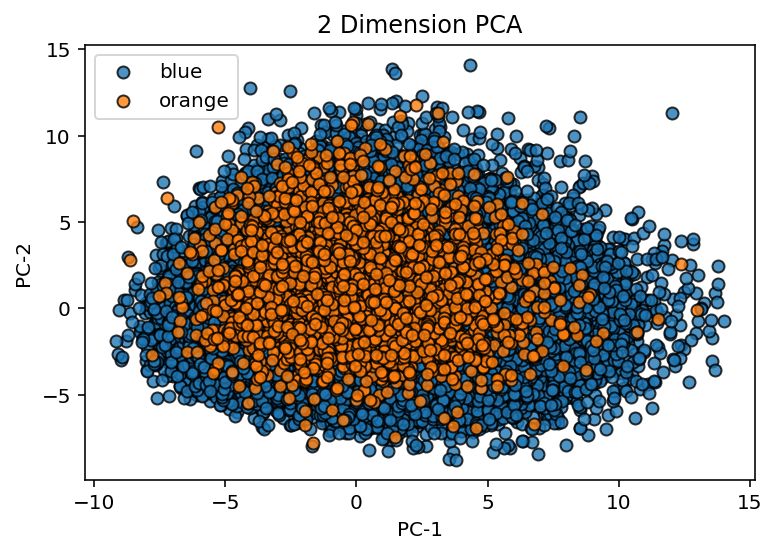

In [45]:
COLORS = {0: "blue", 1:"orange"}
plot_training_points(data_pcs, ys, ["PC-1", "PC-2"], COLORS)

<b>Commentaire</b> : On remarque qu'on a nombre important de données, et qu'avec l'application de la PCA on peut mieux visualiser et différencier les données de la premiére composante et celles de la deuxiéme.
De plus, on peut constater que les données de la deuxiéme composante sont mieux réparties que ceux de la premiére. 

## 5. Modèles de classification

Entrainez le modèle

### Baseline

`LogisticRegression` or `RandomForestClassifier`

In [46]:
SCORINGS = "balanced_accuracy"

<b> Aprés entrainement des modéles mis en commentaire, on a garder celui qui a donné la meilleure valeurs de la balanced accuracy</b>

In [48]:
model = linear_model.LogisticRegression(max_iter=10000)
#model = ensemble.RandomForestClassifier(n_estimators=10)
#model = neighbors.KNeighborsClassifier(n_neighbors=5)
#model = svm.SVC()
#model = tree.DecisionTreeClassifier()
#model = naive_bayes.GaussianNB()
# TODO: Try other models

model.fit(x_train, y_train)  # training

C:\Users\ALGER\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(max_iter=10000)

## 6. Évaluations

In [49]:
y_pred = model.predict(x_valid)  # predictions

score = metrics.balanced_accuracy_score(y_valid, y_pred)  # scoring
#Affichage de la valeur de la balanced accuracy
print(f"Balanced accuracy score: {score:.04f}")
y_valid.value_counts()

Balanced accuracy score: 0.5210


0    23173
1      827
dtype: int64

In [50]:
model1 = tree.DecisionTreeClassifier()
model1.fit(x_train, y_train)  # training

DecisionTreeClassifier()

In [51]:
y_pred = model1.predict(x_valid)  # predictions

score1 = metrics.balanced_accuracy_score(y_valid, y_pred)  # scoring
#Affichage de la valeur de la balanced accuracy
print(f"Balanced accuracy score: {score1:.04f}")
y_valid.value_counts()

Balanced accuracy score: 0.5272


0    23173
1      827
dtype: int64

<b> Commantaire :<b> On remarque que la balanced_accuracy du model1 "DecisionTreeClassifier" est légèrement supérieur  à celui du model "linearRegression" .

### Code : Validation croisée

Le code ci-dessus utilise une méthode simple (*hold out*) pour mesurer le score de validation. Utilisez la validation croisée (pour obtenir une estimation plus fiable) combinée à l'exploration des hyperparamètres (pour améliorer les résultats).

Vous pouvez changer la valeur du nombre de validation croisée (CV) selon la valeur de l'erreur et le temps d'entrainement des modèles (compromis).

In [52]:
CV = 10
SCORING = "balanced_accuracy"

<b>Cross-Validation pour le 1er modele "linearRegression"</b>

In [53]:
#Application de la validation croisée avec les paramétres choisi.
scores = model_selection.cross_val_score(
    model, data_pcs, ys, cv=10, scoring=SCORING
)
print(scores)

print(f"\n{SCORINGS}: {scores.mean():.2f}, with std dev: {scores.std():.2f}\n")

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]

balanced_accuracy: 0.50, with std dev: 0.00



<b>Cross-Validation pour le 2eme modele "decisionTreeClassifier"</b>

In [54]:

scores1 = model_selection.cross_val_score(
    model1, data_pcs, ys, cv=10, scoring=SCORING
)
print(scores1)

print(f"\n{SCORINGS}: {scores1.mean():.2f}, with std dev: {scores1.std():.2f}\n")

[0.525 0.52  0.51  0.526 0.516 0.514 0.514 0.502 0.515 0.526]

balanced_accuracy: 0.52, with std dev: 0.01



<b> Commentaire : </b> On remarque que la CV du premier modele qui est de 50% est inférieure à celle du second qui est de 52% donc à cette étape le modele "decisionTreeClassifier" est plus fiable que le modele "linearRegression".

* **Pour 2 des modèles** (au moins 1 autre que les 2 proposés en baselines) :

    * Pour différentes valeurs d'un des hyperparamètres, donnez les `balanced_accuracy` moyennes de la validation croisée sous forme de Boxplots (ou de diagramme à bâtons avec une barre d'erreur) : voir l'exemple présenté dans le graphique ci-dessous. 
    
    * Explicitez succinctement quelles observations en tirer concernant la stabilité des prédictions.

![](img/boxplot-cv.png)

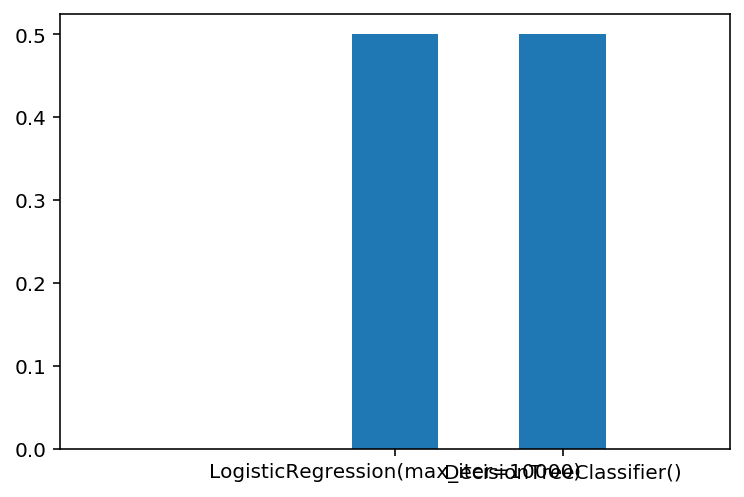

In [55]:
#Le digramme à bar pour le score obtenue de aprés l'application de la validation croisée.
plt.bar([str(model),(str(model1))], scores.mean(),scores1.mean(), yerr=scores.std())
plt.xlim(-2, 2)
plt.show()

<b> Diagramme à barre pour observer la difference de score de la balanced_accuracy entre les deux modeles. </b>

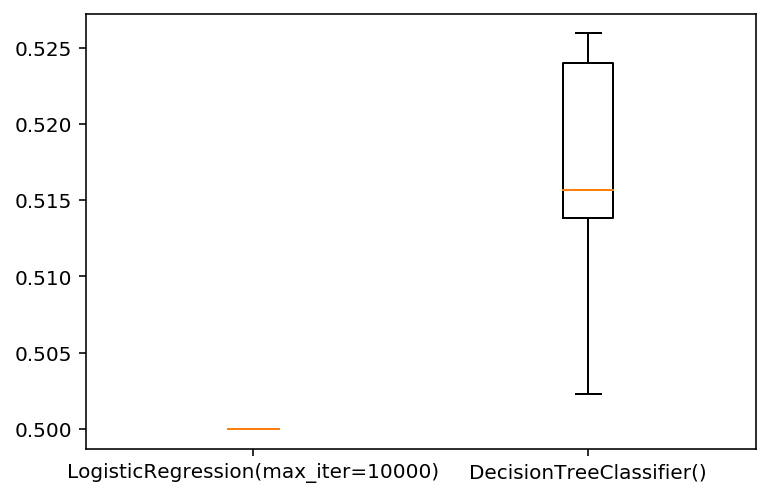

In [56]:
plt.boxplot([(scores),(scores1)])
plt.xticks([1 , 2 ], [str(model),str(model1)])
#plt.xticks([2], [str(model1)])
plt.show()

<b> Boxplot pour observer la difference de score de la balanced_accuracy entre les deux modeles </b>

<b>Pour cette question on a choisi d'utilisé le grid search  : </b>

<b>Grid Search</b>

<b>Dans le grid search suivant on a redéfini la pca avec un processing StandarScaler pour la propreté du code. </b> 

In [58]:
pipe = imblearn.pipeline.Pipeline(
    [
        ("scale", preprocessing.StandardScaler()),
        ("pca", decomposition.PCA()),
        ("model", model),
    ]
)

In [59]:
param_grid = {
    "pca__n_components": [10, 40, 50, 70, 90, 130, 140, 179],
}


search = model_selection.GridSearchCV(
    pipe, param_grid, n_jobs=-1, scoring=SCORINGS, verbose=4, cv=10
)
search.fit(x_1hot_df, ys)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('pca', PCA()), ('resample', SMOTE()),
                                       ('model',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [10, 40, 50, 70, 90, 130, 140,
                                               179]},
             scoring='balanced_accuracy', verbose=4)

In [60]:
print(f"Best parameter (CV score: {search.best_score_:.3f})")

print(search.best_params_)

Best parameter (CV score: 0.747)
{'pca__n_components': 179}


In [61]:
cv_results_df = pd.DataFrame(search.cv_results_)

with pd.option_context("display.float_format", "{:.2g}".format):
    display(cv_results_df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,7.2,2,0.17,0.14,10,{'pca__n_components': 10},0.65,0.66,0.64,0.65,0.65,0.63,0.65,0.65,0.64,0.67,0.65,0.01,8
1,11,2.6,0.14,0.036,40,{'pca__n_components': 40},0.7,0.67,0.71,0.71,0.7,0.69,0.7,0.7,0.69,0.69,0.7,0.0099,6
2,11,1.6,0.15,0.05,50,{'pca__n_components': 50},0.69,0.68,0.7,0.7,0.69,0.71,0.7,0.71,0.7,0.69,0.7,0.01,7
3,15,0.83,0.14,0.016,70,{'pca__n_components': 70},0.71,0.68,0.71,0.69,0.72,0.71,0.71,0.71,0.71,0.69,0.71,0.011,5
4,20,0.97,0.13,0.015,90,{'pca__n_components': 90},0.71,0.7,0.72,0.71,0.71,0.72,0.71,0.71,0.71,0.69,0.71,0.0084,4
5,91,13,0.18,0.029,130,{'pca__n_components': 130},0.72,0.71,0.71,0.72,0.73,0.74,0.73,0.73,0.71,0.72,0.72,0.0096,3
6,1.1e+02,12,0.18,0.021,140,{'pca__n_components': 140},0.73,0.71,0.72,0.74,0.73,0.74,0.73,0.74,0.72,0.73,0.73,0.0085,2
7,27,3.3,0.19,0.061,179,{'pca__n_components': 179},0.75,0.73,0.76,0.77,0.74,0.75,0.75,0.75,0.74,0.74,0.75,0.01,1


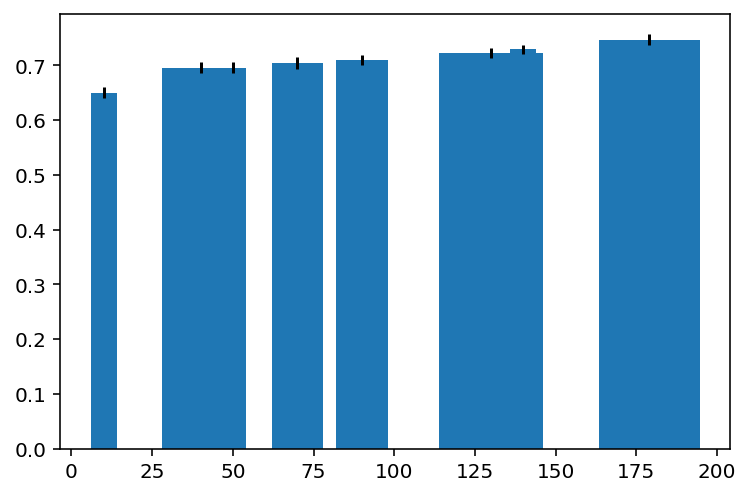

In [62]:
param = search.cv_results_["param_pca__n_components"]

plt.bar(
    search.cv_results_["param_pca__n_components"],
    search.cv_results_["mean_test_score"],
    yerr=search.cv_results_["std_test_score"],
    width=0.8
    * np.diff(search.cv_results_["param_pca__n_components"].data, prepend=0),
)
plt.show()

<b>Commentaire : </b> à chaque fois qu'on augmente les n_components on obtient un score plus élevé de la Cross-Validation jusqu'à atteindre le score maximal qui est de 74% pour le n_compenent = 179.

<b>GridSearch pour le deuxieme model </b>

In [71]:
pipe = imblearn.pipeline.Pipeline(
    [
        ("scale", preprocessing.StandardScaler()),
        ("pca", decomposition.PCA()),
        ("model", model1),
    ]
)

In [72]:
param_grid = {
    "pca__n_components": [10, 40, 50, 70, 90, 130, 140, 179],
}


search = model_selection.GridSearchCV(
    pipe, param_grid, n_jobs=-1, scoring=SCORINGS, verbose=4, cv=10
)
search.fit(x_1hot_df, ys)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('pca', PCA()), ('resample', SMOTE()),
                                       ('model', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'pca__n_components': [10, 40, 50, 70, 90, 130, 140,
                                               179]},
             scoring='balanced_accuracy', verbose=4)

In [73]:
print(f"Best parameter (CV score: {search.best_score_:.3f})")

print(search.best_params_)

Best parameter (CV score: 0.563)
{'pca__n_components': 50}


In [74]:
cv_results_df = pd.DataFrame(search.cv_results_)

with pd.option_context("display.float_format", "{:.2g}".format):
    display(cv_results_df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,17,3.2,0.12,0.052,10,{'pca__n_components': 10},0.56,0.54,0.55,0.54,0.55,0.53,0.52,0.53,0.52,0.56,0.54,0.015,8
1,43,3.5,0.11,0.018,40,{'pca__n_components': 40},0.57,0.54,0.56,0.57,0.55,0.54,0.59,0.54,0.57,0.57,0.56,0.018,3
2,50,1.5,0.099,0.015,50,{'pca__n_components': 50},0.56,0.56,0.59,0.57,0.57,0.57,0.55,0.54,0.58,0.55,0.56,0.016,1
3,69,3.1,0.11,0.0084,70,{'pca__n_components': 70},0.55,0.56,0.56,0.54,0.54,0.56,0.55,0.57,0.55,0.55,0.55,0.008,6
4,90,2.7,0.1,0.0091,90,{'pca__n_components': 90},0.56,0.55,0.57,0.52,0.57,0.55,0.56,0.54,0.56,0.55,0.55,0.014,5
5,1.3e+02,3.6,0.12,0.017,130,{'pca__n_components': 130},0.57,0.56,0.56,0.57,0.56,0.58,0.57,0.54,0.55,0.54,0.56,0.012,2
6,1.5e+02,3.1,0.11,0.0012,140,{'pca__n_components': 140},0.55,0.55,0.54,0.55,0.56,0.55,0.55,0.54,0.56,0.56,0.55,0.008,7
7,1.9e+02,17,0.13,0.032,179,{'pca__n_components': 179},0.57,0.58,0.56,0.57,0.55,0.58,0.57,0.55,0.53,0.55,0.56,0.015,4


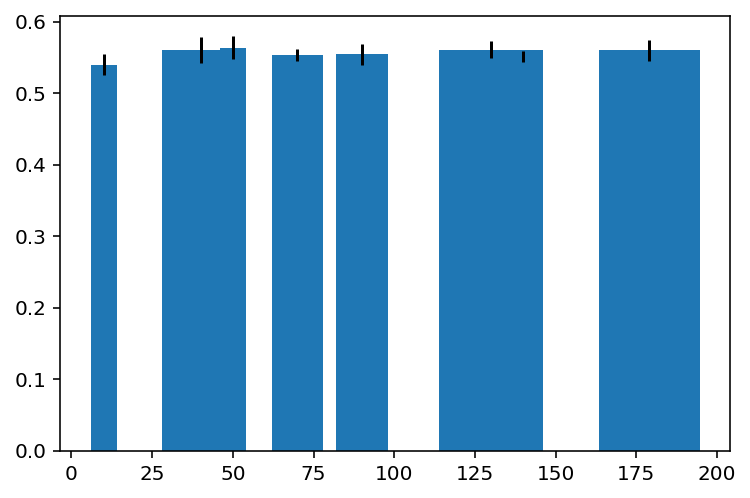

In [75]:
param = search.cv_results_["param_pca__n_components"]

plt.bar(
    search.cv_results_["param_pca__n_components"],
    search.cv_results_["mean_test_score"],
    yerr=search.cv_results_["std_test_score"],
    width=0.8
    * np.diff(search.cv_results_["param_pca__n_components"].data, prepend=0),
)
plt.show()

<b>Commentaire : </b> On remarque qu'au-delà de n_compenent = 50 on a plus ou moins le meme score. 
le score maximal qui est de 56% pour le n_compenent = 50

* <b> Commentaire : </b> Apres application de GridSearch avec le model linearRegression on a pu obtenir le meilleur hyperparametre pour avoir le meilleur score qui est de 74%.
*     Avec le model decisionTree on obtient un score plus ou moins élevé par rapport balanced_accuracy de ce model.
* <b> Comparaison : </b> On remarque que le score du model decisionTree avec le meilleur hyperparametre est inférieur de 20% à celui du model linearRegression.

* **Pour chacun de ces 2 modèles, à partir des données de validation créées précédemment** (`x_valid`, `y_valid`) :

    * Mesurez l'aire sous la courbe ROC (AUC) à l'aide de la fonction de Scikit-Learn (`roc_auc_score`) et comparez les modèles avec leur combinaison respective d'hyperparamètres offrant le meilleur résultat.

In [76]:

metrics.roc_auc_score(y_valid,model.predict_proba(x_valid)[:, 1])

0.829968329797985

In [77]:
metrics.roc_auc_score(y_valid,model1.predict_proba(x_valid)[:, 1])

0.5271580083375814

* <b> Commentaire :</b> On constate que l'aire sous la courbe avec le modele linearRegression est de 0.83 qui se rapproche énormement de 1 contrairement à celui du model1 decisionTreeClassifier qui est de 0.52, donc on deduit que le modele linearRegression est plus fiable et nous donnera une classification mieux adaptée. 

* **Pour le modèle et sa combinaison d'hyperparamètres offrant le meilleur résultat** :

    * Réalisez la matrice de confusion et décrivez-la succinctement.

<b> La matrice de confusion pour le model offrant le meilleur resultat : "linearRegression" </b>

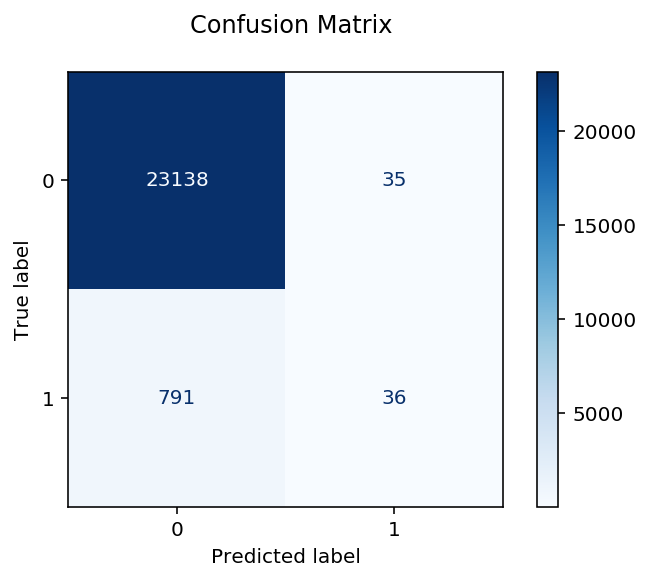

In [87]:
disp = metrics.plot_confusion_matrix(model, x_valid, y_valid, cmap=plt.cm.Blues)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

<b> Commentaire :</b> On constate de la matrice de confusion que le modele a predit 23138 "0" en étant des "0" et 36 "1" comme étant des "1" dans ce cas la prédictions a été bien faite, mais il a prédit 35 "0" comme étant des "1" ce qui fait un taux d'erreur de 0.15 % sur la prédiction des "0".Il a prédit également 791 "1" comme étant des "0" ce qui fait un taux d'erreur de 95,6% sur la prédicition des "1" ce qui fait que le model n'est pas aussi fiable sur la prediction des "1" que sur la prédiction des "0".

### Code : Essayez d'améliorer votre score

* Data augmentation (optionnel)

Vu le déséquilibre entre les classes à prédire (survive, died), on peut espérer améliorer le score en les rééquilibrant. Une approche typique est la génération de données (voir cours : `part-6-slides.pdf`). Une des méthodes de génération est [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE) (voir cours théorique), elle est notamment implémentée dans le module `imblearn`.

`imblearn` a été développé pour s'interfacer facilement avec `sklearn`.
Il propose notamment une version du `pipeline` qui permet l'intégration avec `sklearn`.

Ci-dessous voici un exemple de `pipeline` intégrant `imblearn` et `sklearn`.

In [90]:
# TODO: Data augmentation

pipe = imblearn.pipeline.Pipeline(
    [
        ("scale", preprocessing.StandardScaler()),
        ("pca", decomposition.PCA()),
        ("resample", imblearn.over_sampling.SMOTE()),
        ("model", model),
    ]
)

### Explication de ce que vous avez réalisé, conclusion et perspectives

* Commencez par donner votre meilleur résultat obtenu lors de vos soumissions

* Expliquez le chemin qui vous y a conduit

    * Ce que vous avez essayé :

        * Ce qui a fonctionné

        * Ce qui n'a pas fonctionné et comment vous l'avez solutionné

    * Quelle méthode avez-vous utilisée pour choisir les hyperparamètres ?

    * Comparer la durée d'entrainement des principaux modèles utilisés ?

* Qu'auriez-vous fait si vous aviez eu plus de temps ?

<b>
*Le meilleur résultat obtenu lors de nos soumission est : 0.54.

*Le chemin qu'on a suivis : Pour chaque étape de réalisation de ce projet :
    * On a été guider par les instructions indiquées sur l'énoncé.
    *Pour chaque étape soit : l'exploration des données, le traitement , l'application de la PCA, la classification et validation croisée, l'évaluation avec la blanced_accuracy, la matrice de confusion et la l'air sous la courbe pour l'évaluation, on s'est inspiré des connaissance qu'on a eu pendant le cours et les TP déja réalisés.

*Tout a fonctionner à part la partie optionnelle sur l'augmentation qu'on a pas pu aborder, car on essayait à différentes reprise d'augmenter le score de la balanced_accuracy de la classification.

*La méthode utilisée pour choisir les hyperparamétres : est la méthode du Grid Search "GridSearchCV" qui permet de tester plusieurs paramètres via la cross-validation ainsi que choisir le meilleur nombre de composante principale pour la PCA.

*La durée d'entrainement la plus longue est celle du modele :  LogisticRegression ensuite le model dataDecisionTreeCalsifier et SVC, et puis on aura une durée plus ou moins égale pour les autres modéles tel que  : NaiveBayes et randomForest

    Si on avez le temps : 
*Completer le projet avec l'implementation de la partie de l'augmentation.
*Essayer d'avoir le meilleur résultat pour la Pca, Validation_Croisée, classification aisni que tester d'autre modéles qui sont peut-être mieux adapter à ce type de données.

</b>

### Question (optionnelle)

* Qu'est-ce que le suréchantillonnage ? 

* En quoi pourrait-il être utile dans ce problème ?

<b>*Le suréchantillonnage : est une technique pour équilibrer la nature déséquilibrée de l'ensemble de données. Il équilibre les données en reproduisant les échantillons des classes minoritaires mais cela n'entraîne aucune perte d'informations, donc le dataset subira un surajustement car les mêmes informations sont copiées.

*Vu que le dataset dans ce probléme a un déséquilibre entre les classes à prédir, donc tenter de le réequilibrer serait une trés bonne idée pour éviter que les models appliqués pour la classification apprenent uniquement de la classe majoritaire et aboutissent à une prédiction biaisée.

de plus avec le suréchantillonnage on aura pas de classe majoriataire ou minoriatire, ce qui nous aidera à améliorer le score et les résulatats de la prédiction faites sur le dataset.</b>

## 7. Enregistrer les prédictions

* Utilisez le code suivant pour faire des prédictions et pour les enregistrer sous forme de fichier ZIP
* Soumettez ce fichier ZIP sur [le site du challenge](https://competitions.codalab.org/competitions/30715#participate-submit_results)
("Participate > Submit/View Results > Submit")
* Faites de votre mieux pour être le ***premier sur le leaderboard !***

<span style="color:red">
    !! Ne pas oublier de modifier la commande de la prédiction selon les données et modèles choisis !!
</span>

* Données : `x_test_fact_df`, `x_test_1hot_df`

* Modèles : `model`, `search` (e.g., pour le `GridSearchCV`)

In [12]:
predictions = model.predict(x_test_1hot_df)  # compute predictions
# VARS: x_test_df, x_test_fact_df, x_test_1hot_df, x_test_1hot_pcs
# Models: model, search


PRED_PATH.mkdir(parents=True, exist_ok=True)

t_stamp = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
submission_fp = PRED_PATH / f"submission_{t_stamp}.zip"

pred_fname = "mimic_synthetic_test.csv"
compr_opts = dict(method="zip", archive_name=pred_fname)

pd.Series(predictions).to_csv(
    submission_fp, compression=compr_opts, index=False, header=False
)

print(f"The submission is ready: {submission_fp}")

NameError: name 'model' is not defined

---

# Remarque sur le jeu de données

Le jeu de données ne contient pas de données médicales réelles. Nous ne sommes pas autorisés à partager ces **données confidentielles** provenant de patient·e·s en soins intensifs. Pour éviter ce problème, les données ont été remplacées par des **données artificielles**.

Afin d'avoir des données crédibles, elles ont été générées à l'aide d'un réseau adverse génératif (**GAN**) Wasserstein.

Pour plus d'informations, voici une référence : <br />
[Privacy Preserving Synthetic Health Data](https://hal.inria.fr/hal-02160496/document) <br />
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, Kristin Bennett <br />

---